# Importing Necessary Libraries

In [88]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from collections import defaultdict
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve
from itertools import compress

%matplotlib inline

rs = 101

 # Task 1. Data Selection and Distribution. 

In [2]:
## Read Data
df = pd.read_csv("CaseStudyData.csv")

/home/chihcheng/python3env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 ### 1. What is the proportion of cars who can be classified as a “kick”? 

In [3]:
## Exploring the features in this dataset
print("Number of Columns: ", len(df.columns))
print("Columns: ",list(df.columns))

Number of Columns:  31
Columns:  ['PurchaseID', 'PurchaseTimestamp', 'PurchaseDate', 'Auction', 'VehYear', 'Make', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'PRIMEUNIT', 'AUCGUART', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ForSale', 'IsBadBuy']


In [4]:
print("Number of Observations: ", len(df))

Number of Observations:  41476


In [5]:
proportionOfKicks = len(df[df['IsBadBuy'] == 1]) / len(list(df['IsBadBuy']))
print("The proportion of kicks: ", proportionOfKicks)

The proportion of kicks:  0.1294965763333012


### 2. Did you have to fix any data quality problems? Detail them.

In [6]:
### Define all the column attributes
drop_cols = ['PurchaseID','PurchaseDate']
categorial_cols = ['Auction', 'VehYear', 'Make', 'Color', 'Transmission','WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName','PRIMEUNIT','AUCGUART','VNST','IsOnlineSale','ForSale' ] # Replaced by the most common 
interval_cols = ['PurchaseTimestamp', 'VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost' ] # Replaced by the mean
replaced_vals = ['?', '#VALUE!']

### Replacing '?' and '#VALUE!' by null
for replaced in replaced_vals:
        df.replace(replaced, float('nan'),inplace = True)
            
print("Total null in the dataset: ", df.isnull().sum().sum())

Total null in the dataset:  85508


In [7]:
### Show null in each column
nullValues = defaultdict(int)
for colName in df.columns:
#     print("Column " + str(colName) + " has " + str(df[colName].isnull().sum()) +" null values")
    nullValues[colName] = df[colName].isnull().sum()
display(pd.DataFrame(nullValues, index=[0]).transpose())

,0
PurchaseID,0
PurchaseTimestamp,0
PurchaseDate,0
Auction,44
VehYear,44
Make,44
Color,50
Transmission,50
WheelTypeID,1819
WheelType,1873


In [8]:
def data_prep(df):
    
    '''
    For Preprocessing the Data
    '''
    
    ### Check the replaced values are not in the dataset
    for replaced in replaced_vals:
        df.replace(replaced, float('nan'),inplace = True)
    
    for colName in df.columns:
        
        if colName in categorial_cols:
            
            ## Try to lower the data if the data type is string
            try:
                df[colName] = df[colName].str.lower()
            except:
                print(colName, " can't be lowered")

            df[colName] = df[colName].astype('category')
            
            ### Replacing the null by the most common category
            df[colName].fillna(df[colName].astype('category').describe()['top'], inplace=True)
        
        if colName in interval_cols:
            
            df[colName] = df[colName].astype('float')
            
            # Removing outlier
            df = df[df[colName] < df[colName].quantile(0.999)]
            
            # Replacing the null by the mean
            df[colName].fillna(df[colName].astype('float').mean(), inplace=True)
            
    df.drop(drop_cols, axis=1, inplace = True)
    
    return df

In [9]:
df = data_prep(df)

/home/chihcheng/python3env/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/chihcheng/python3env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chihcheng/python3env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

VehYear  can't be lowered


/home/chihcheng/python3env/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### 3. Can you identify any clear patterns by initial exploration of the data using histogram or box plot?

In [10]:
def plotAllCols (df):
    for colName in df.columns:
        plt.figure(figsize=(20,10))
        if colName in categorial_cols:
            ### if it's categorial column, plot hist diagram 
            sns.countplot(x=colName, data = df, hue="IsBadBuy")
        elif colName in interval_cols:
            ### if it's interval column, plot box diagram
            sns.boxplot(x="IsBadBuy", y=colName, data = df )

/home/chihcheng/python3env/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


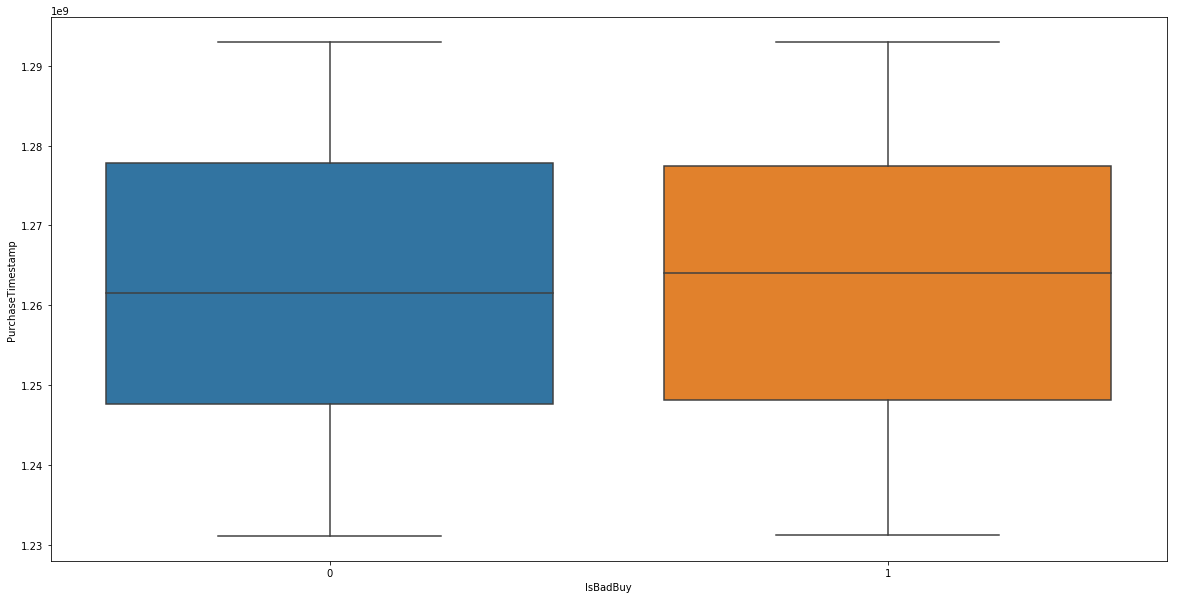

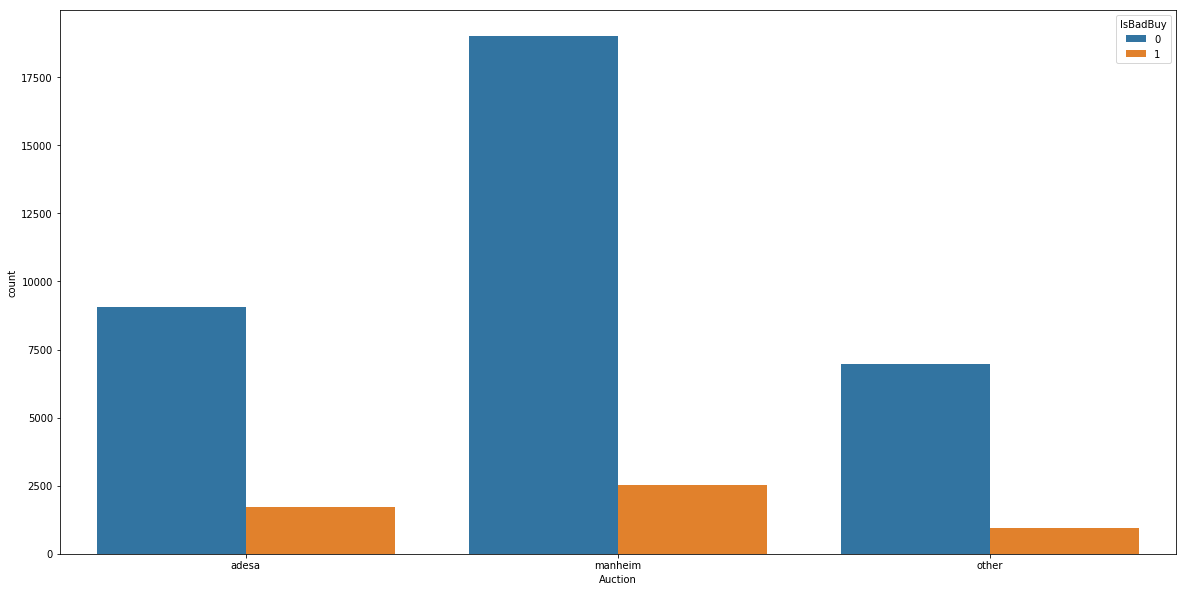

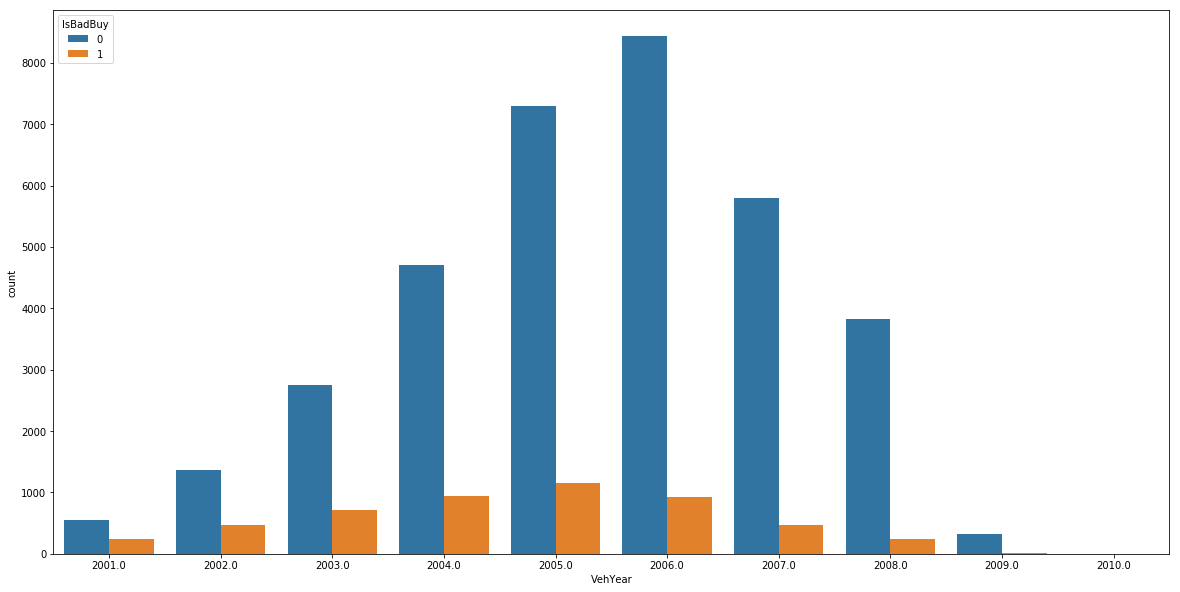

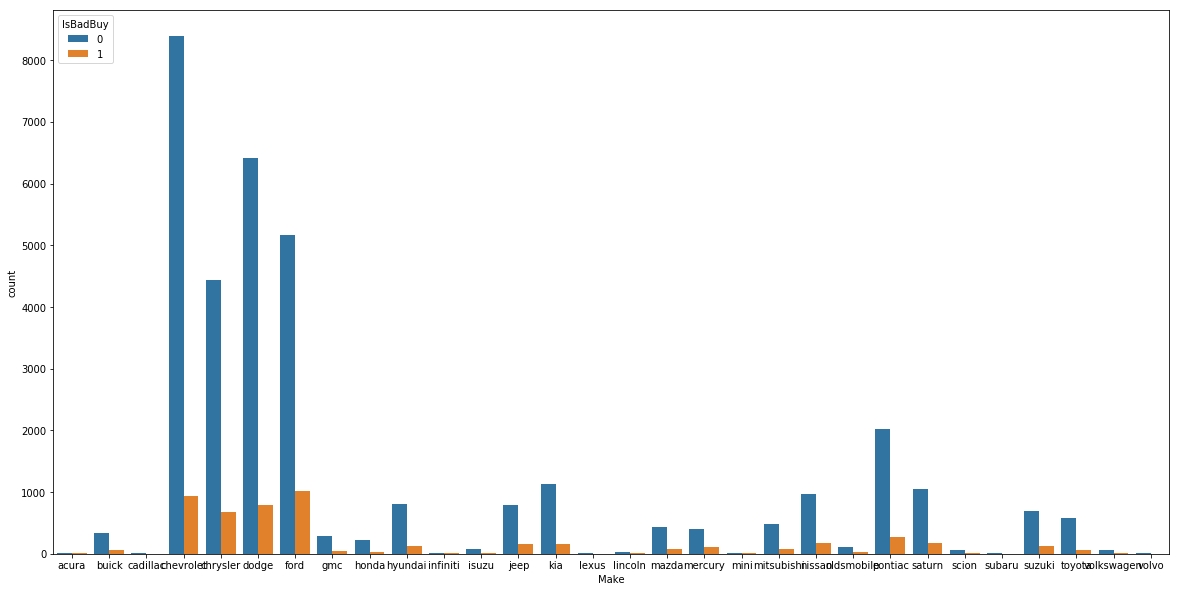

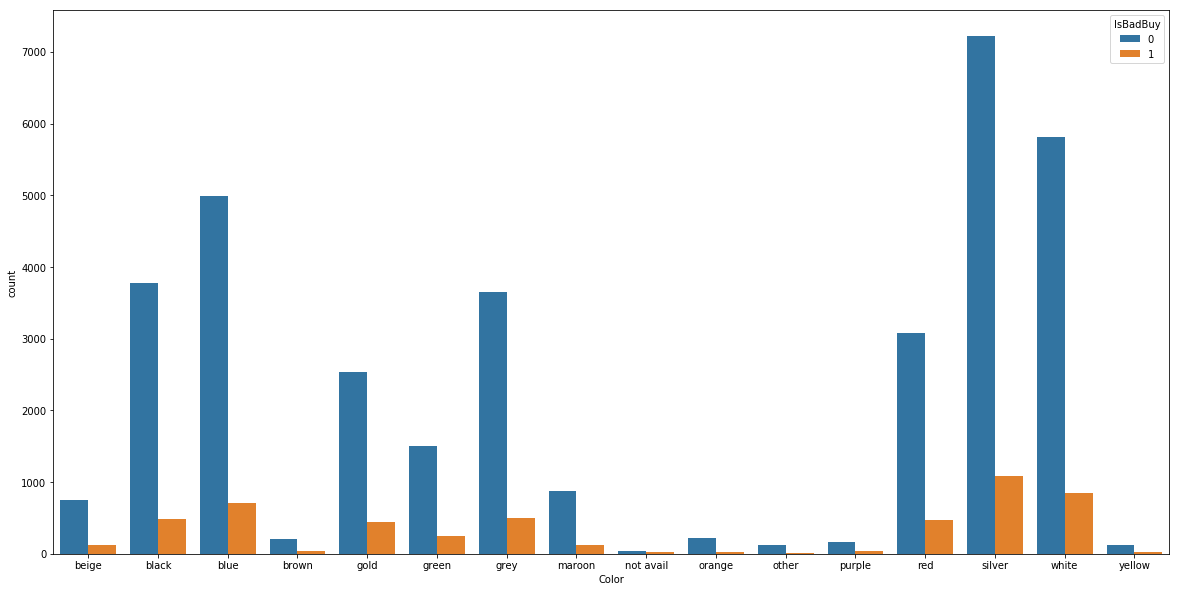

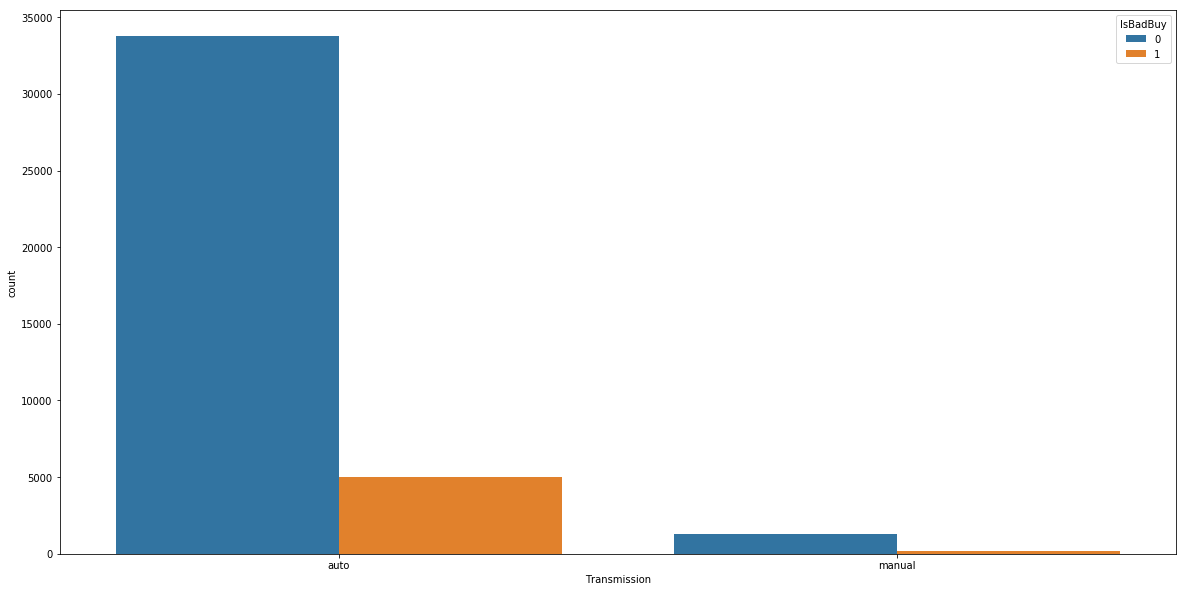

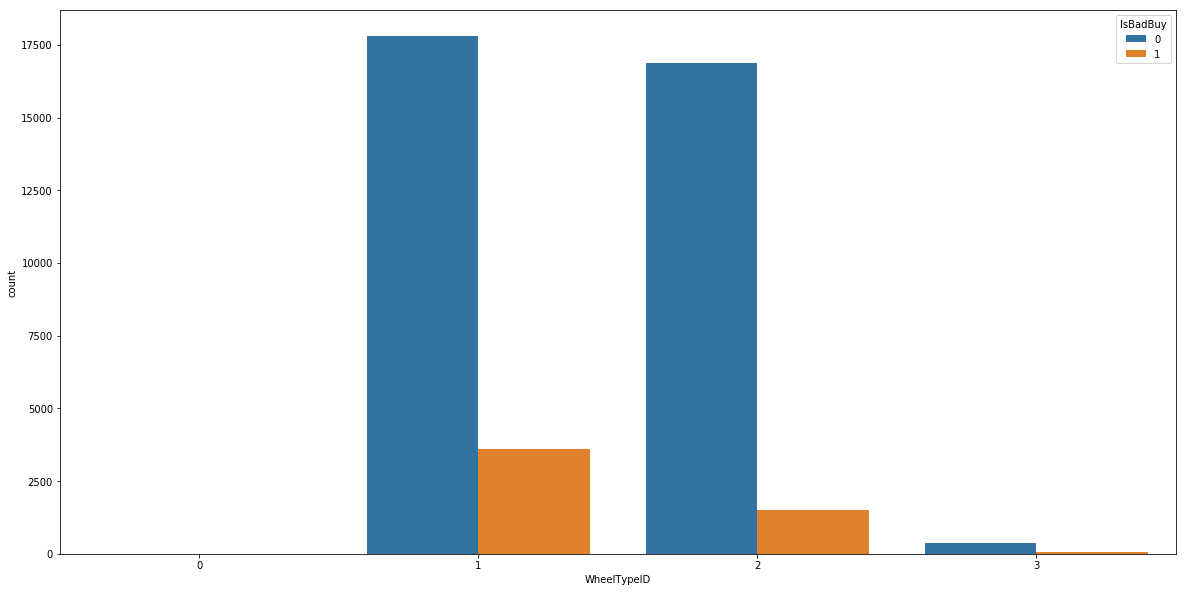

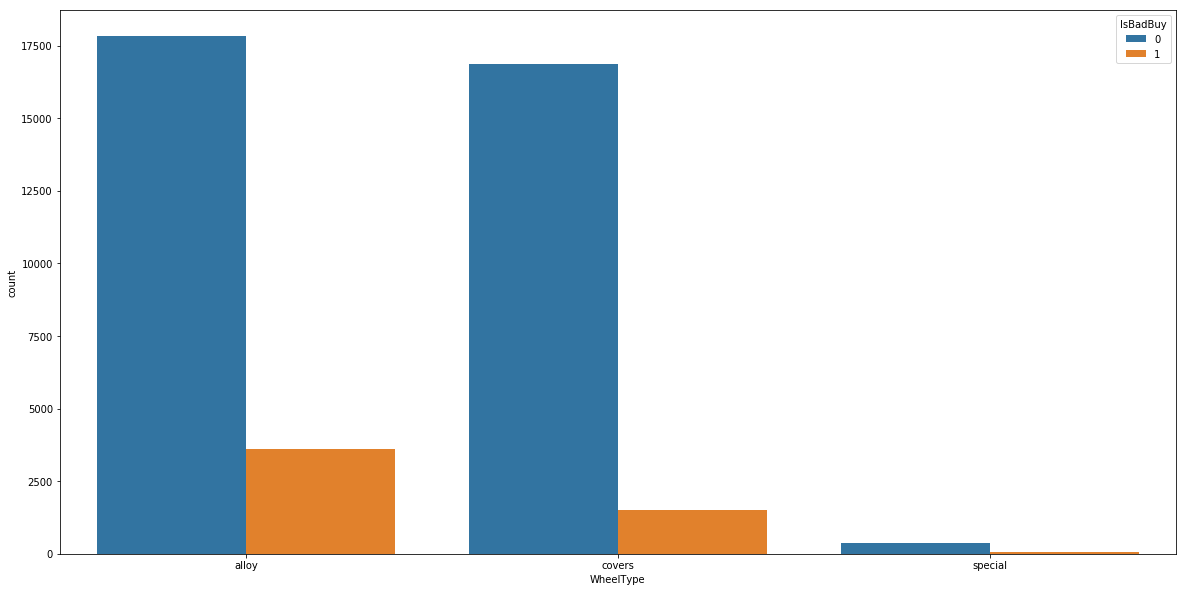

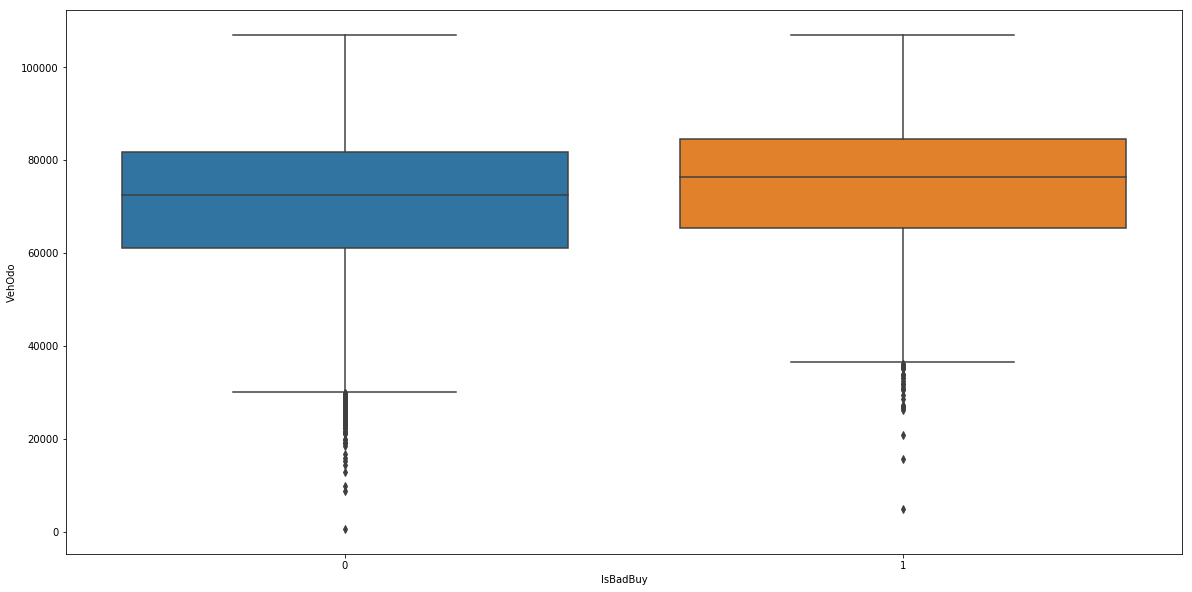

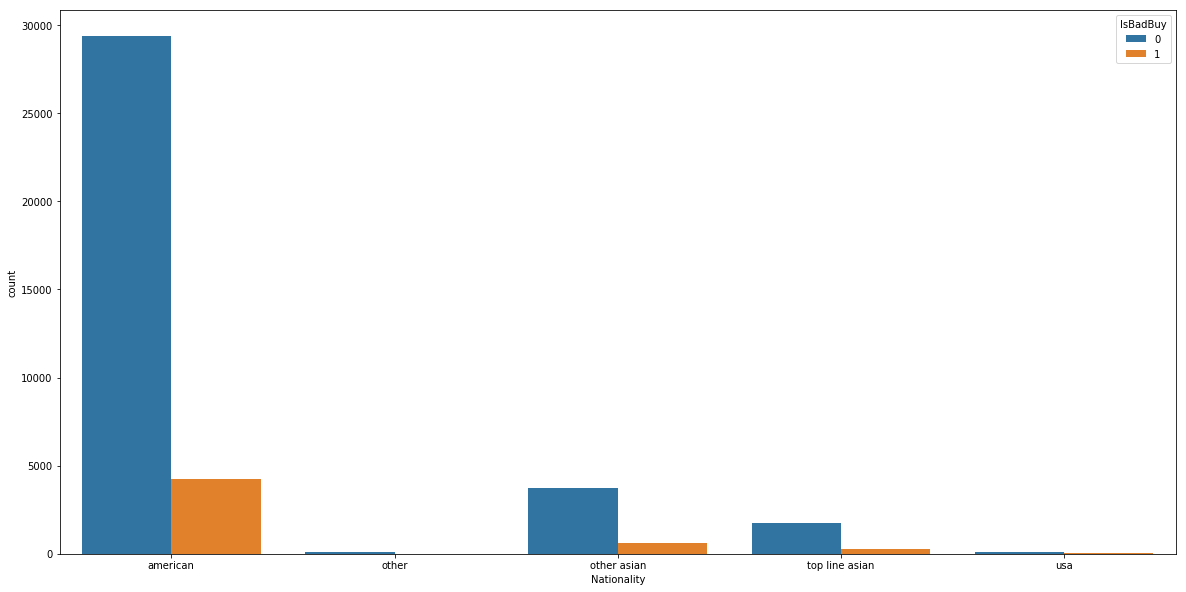

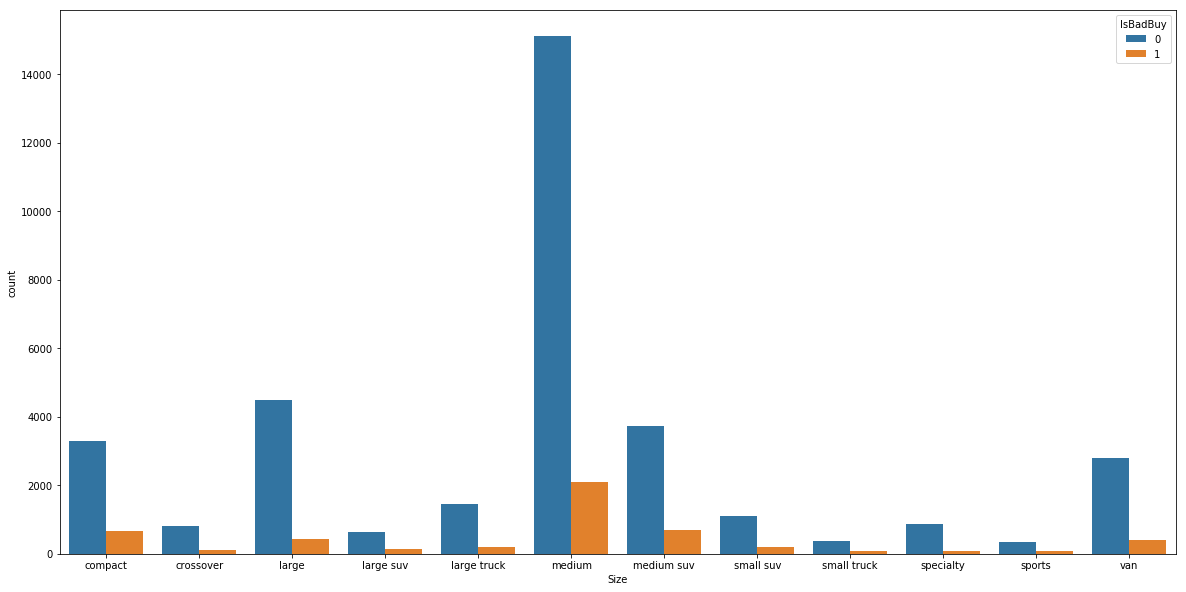

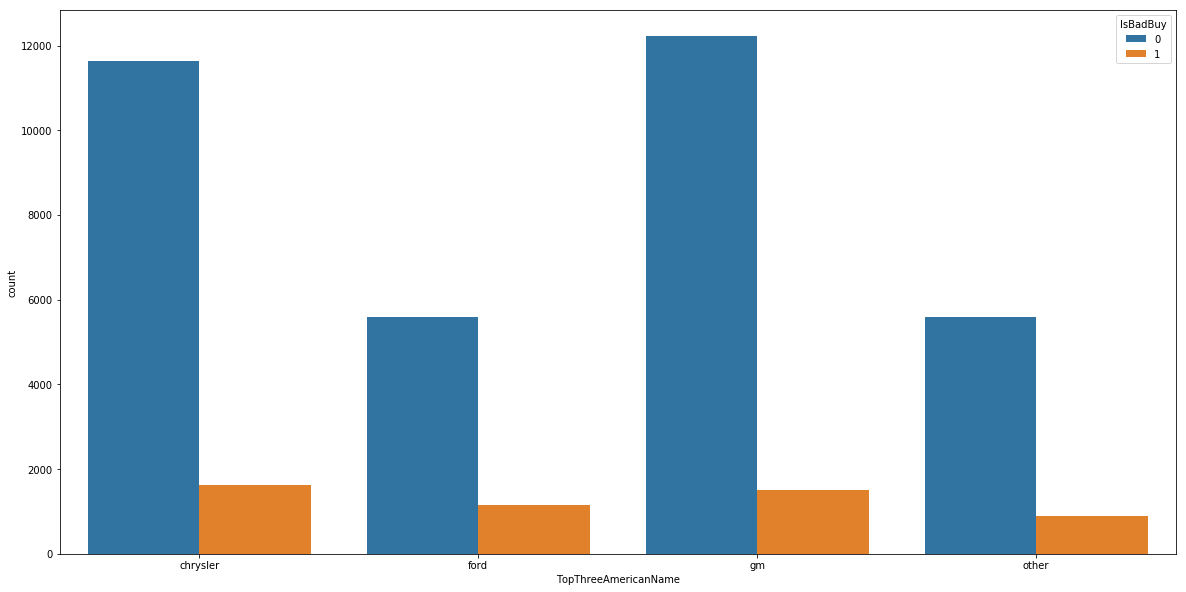

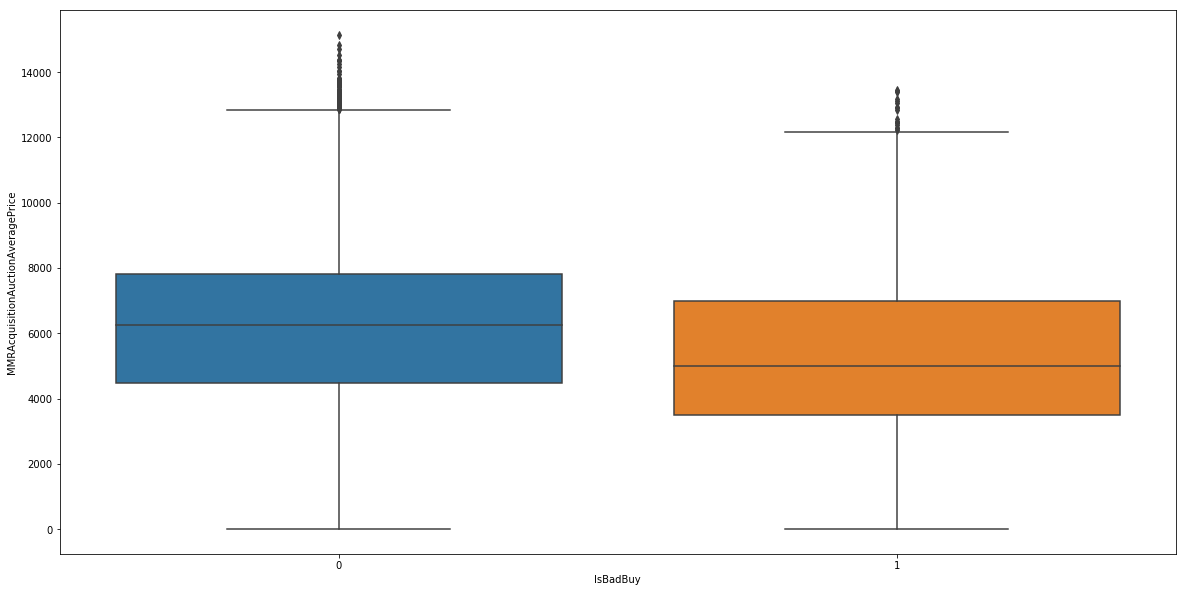

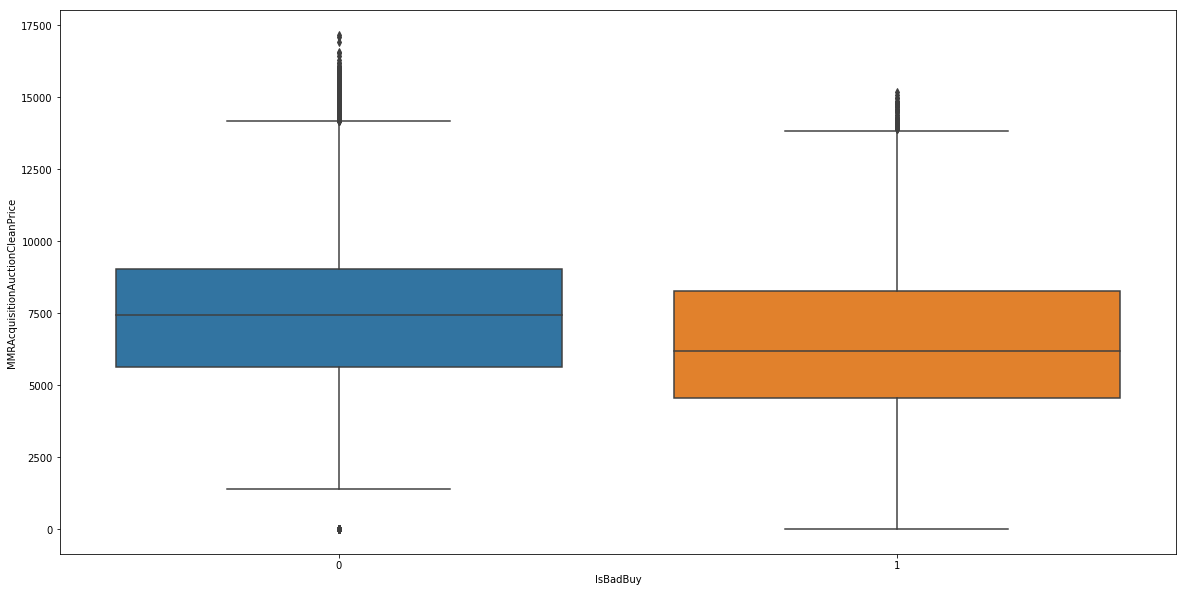

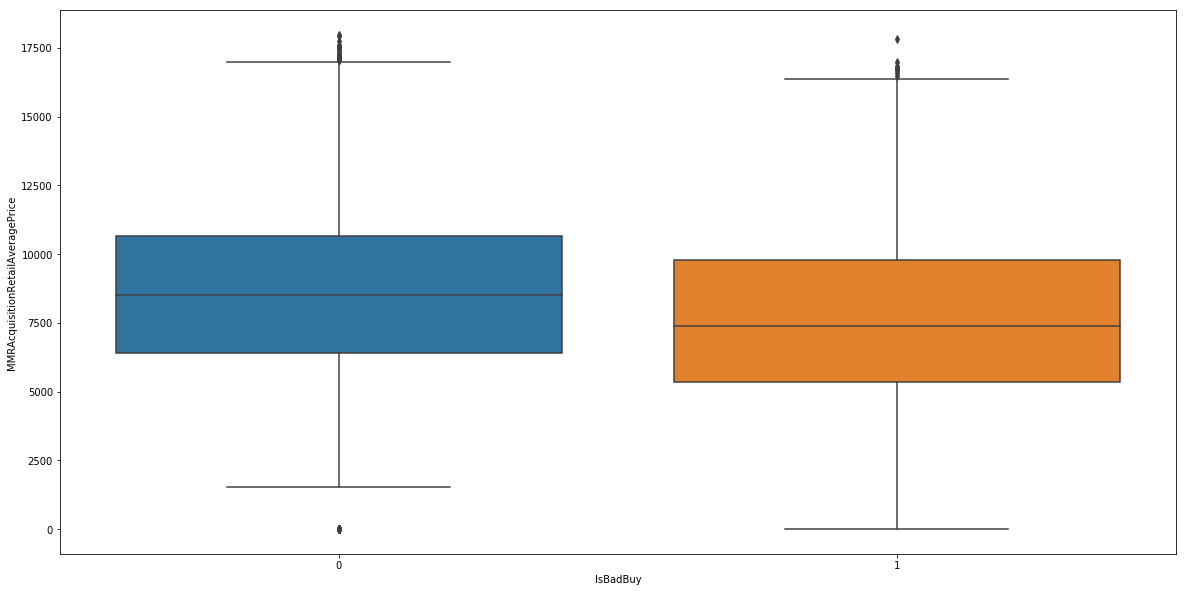

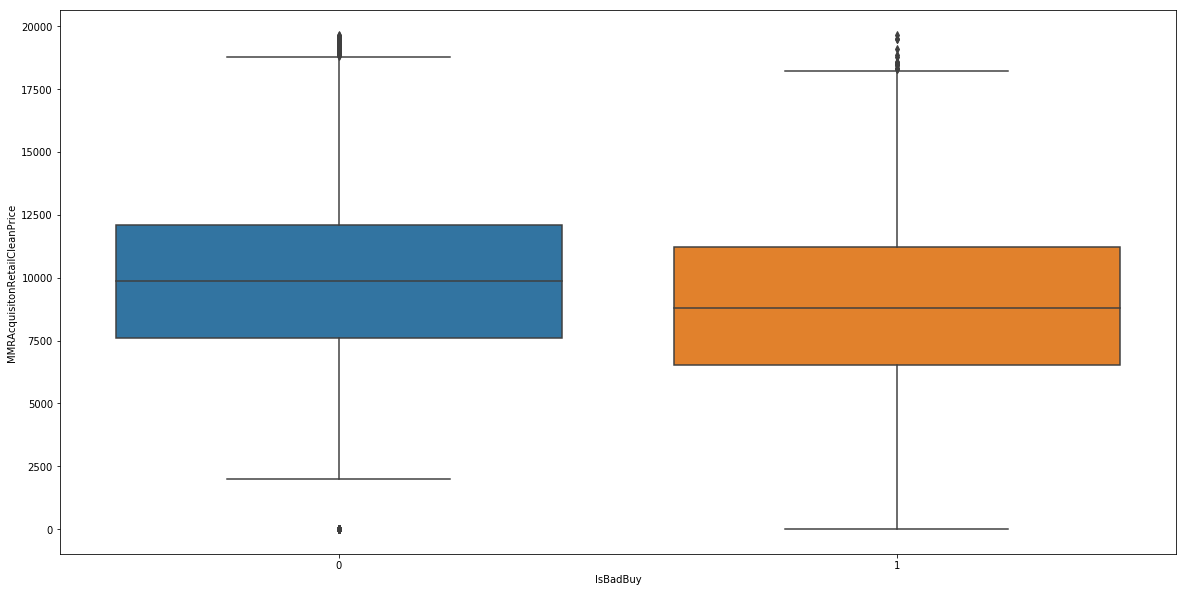

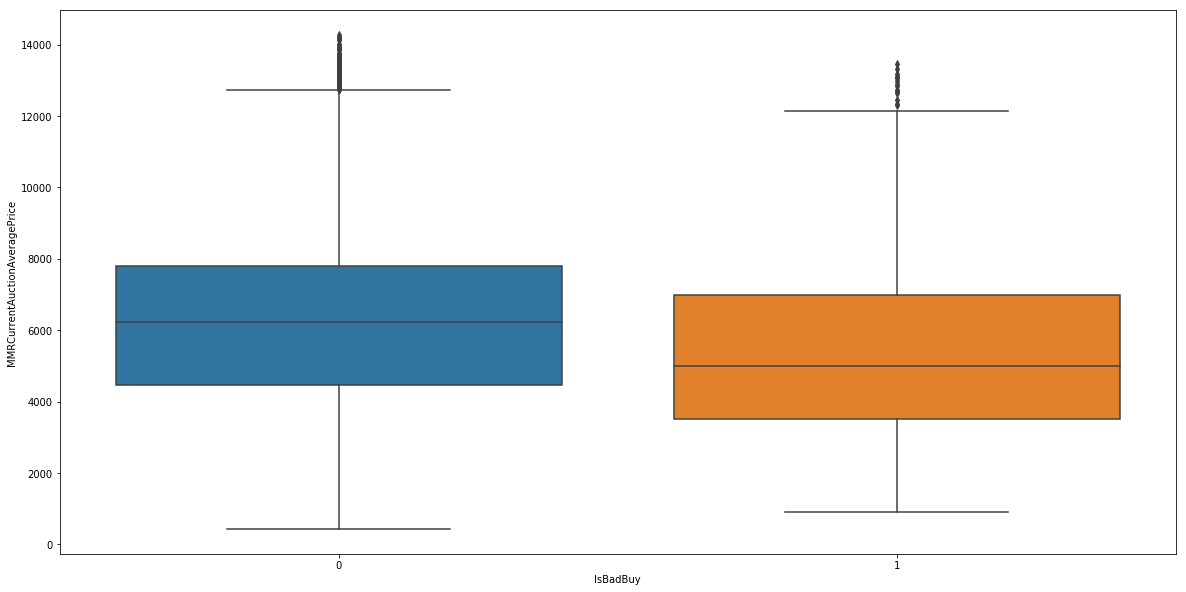

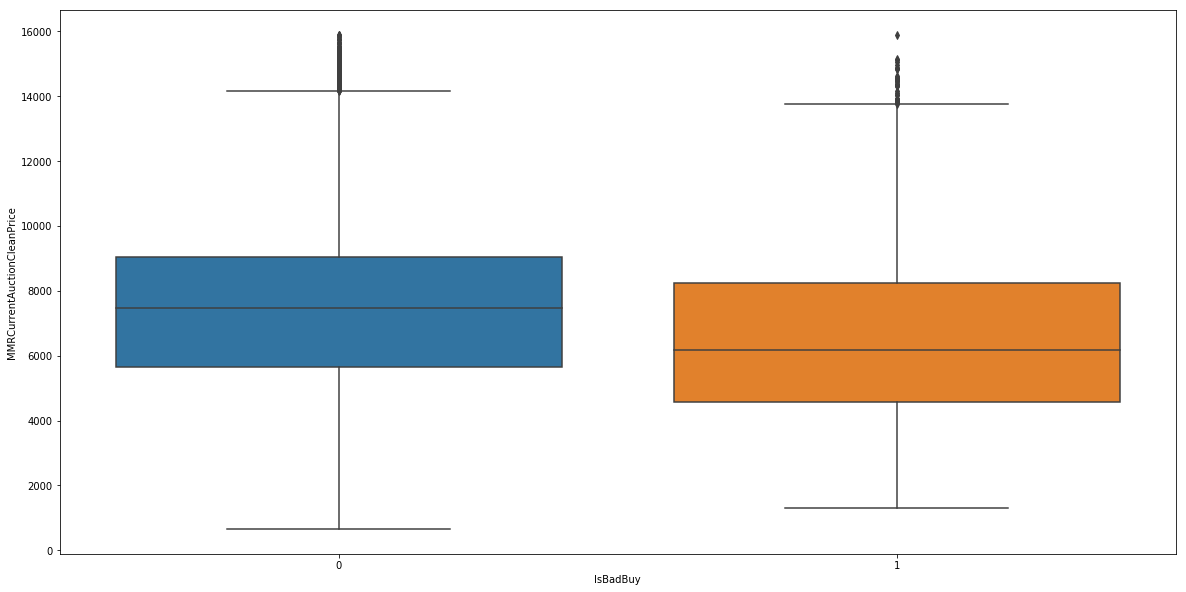

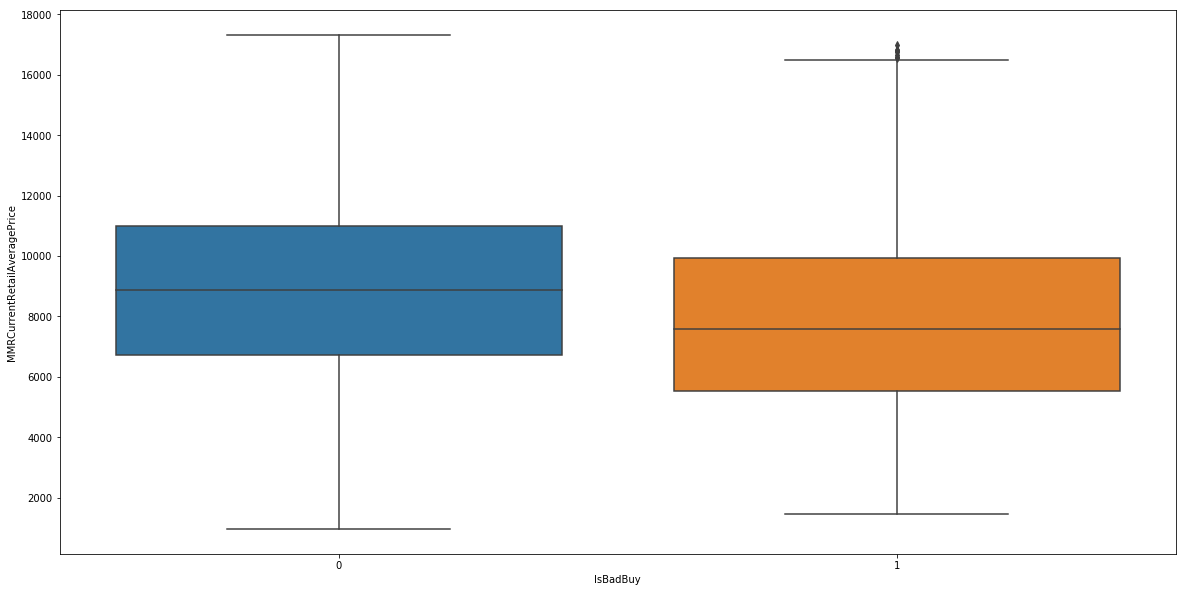

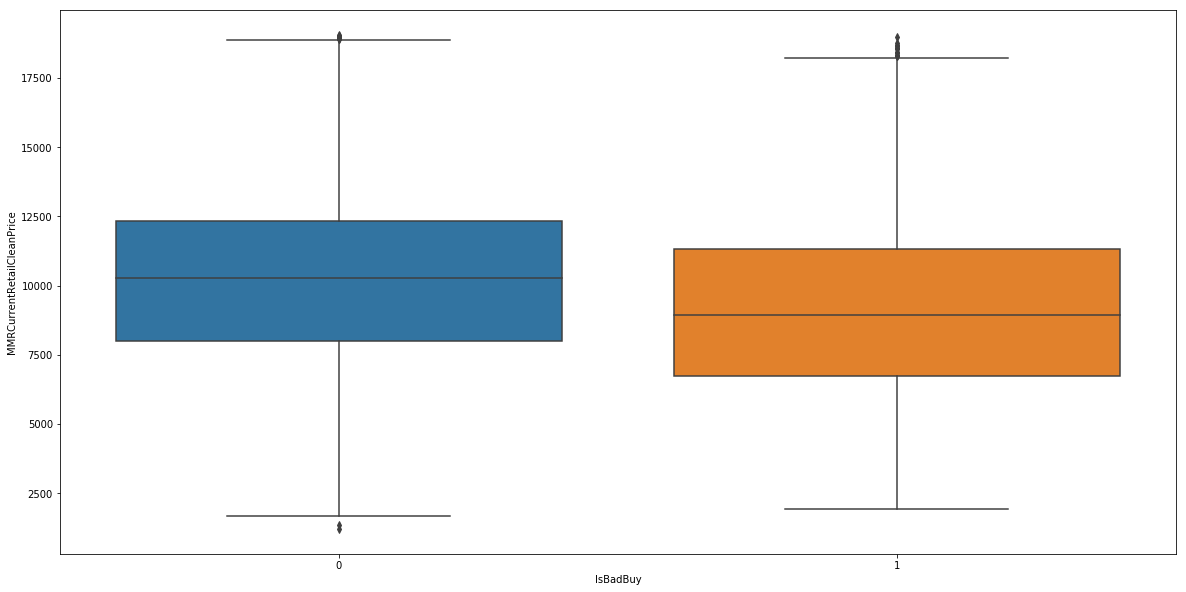

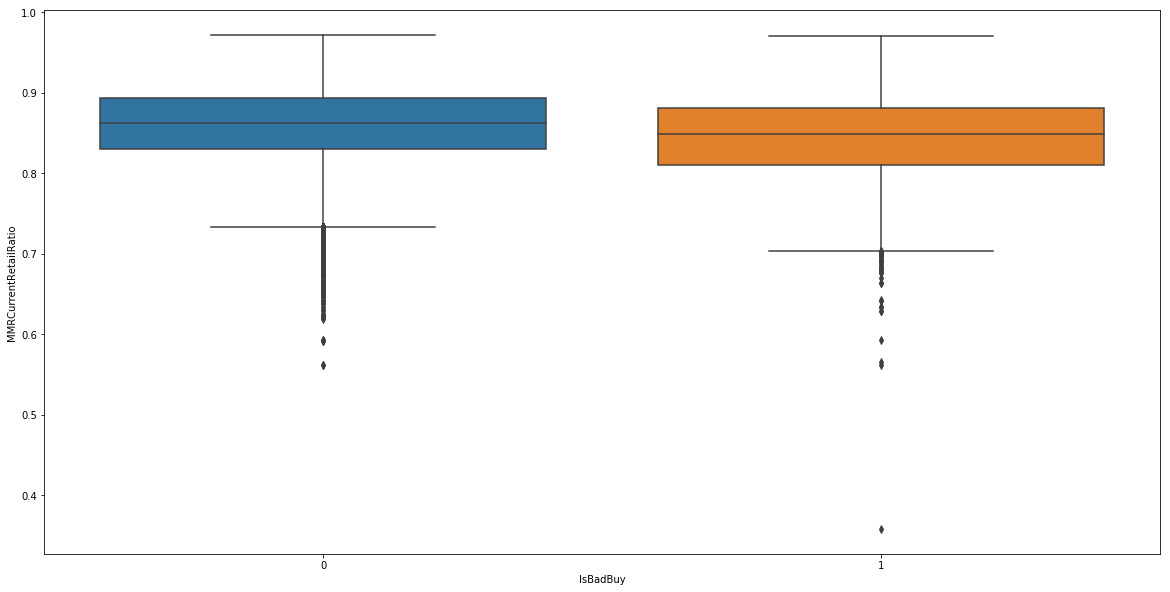

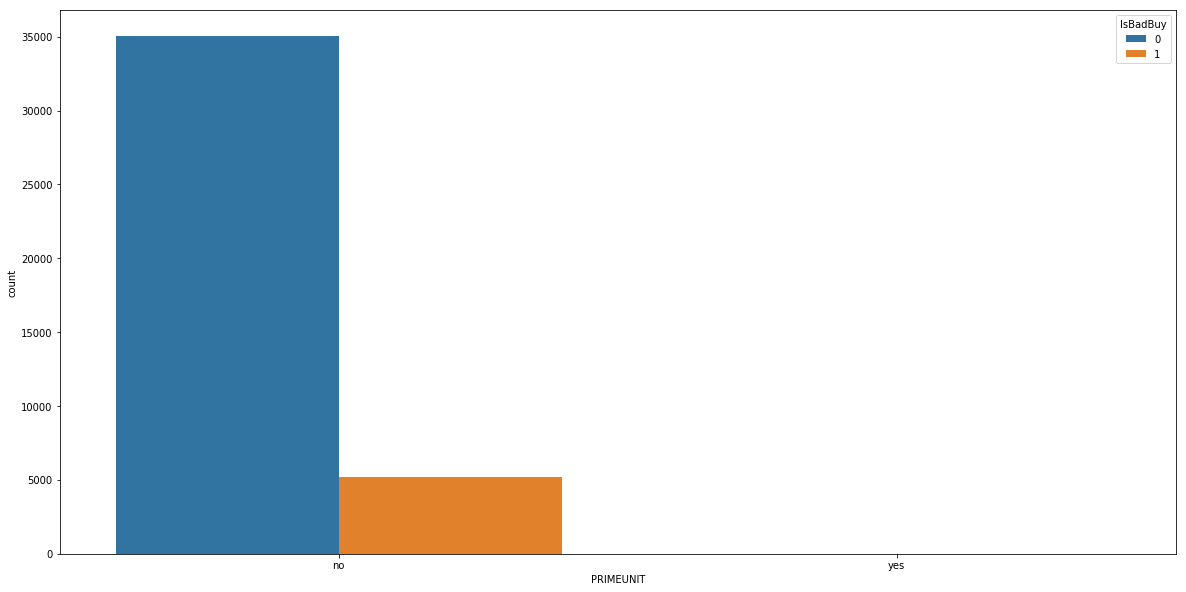

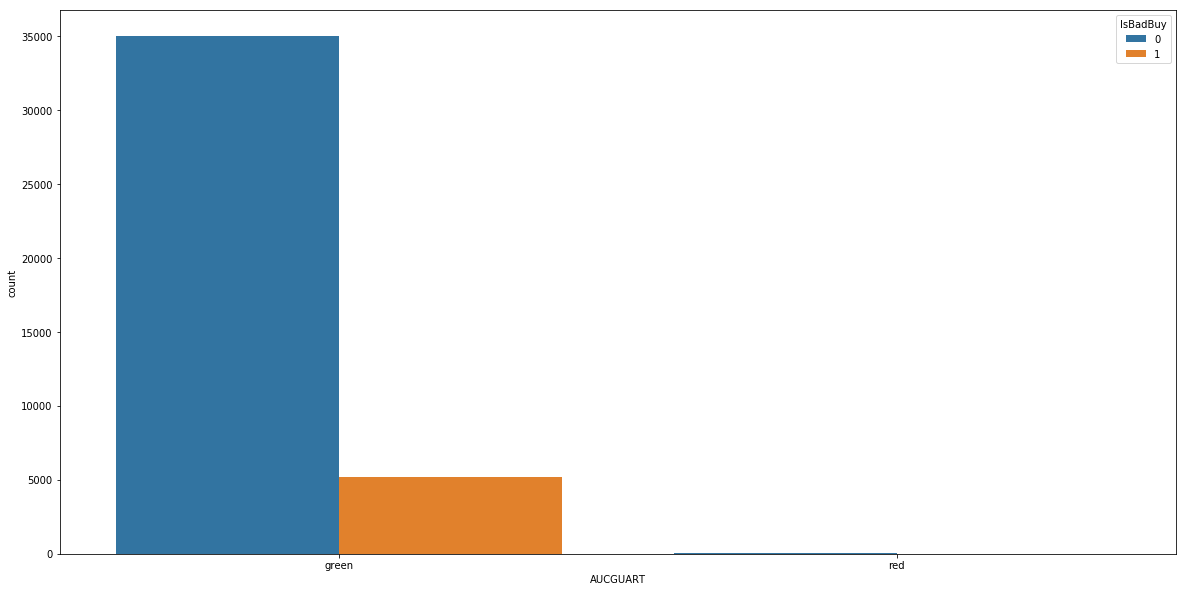

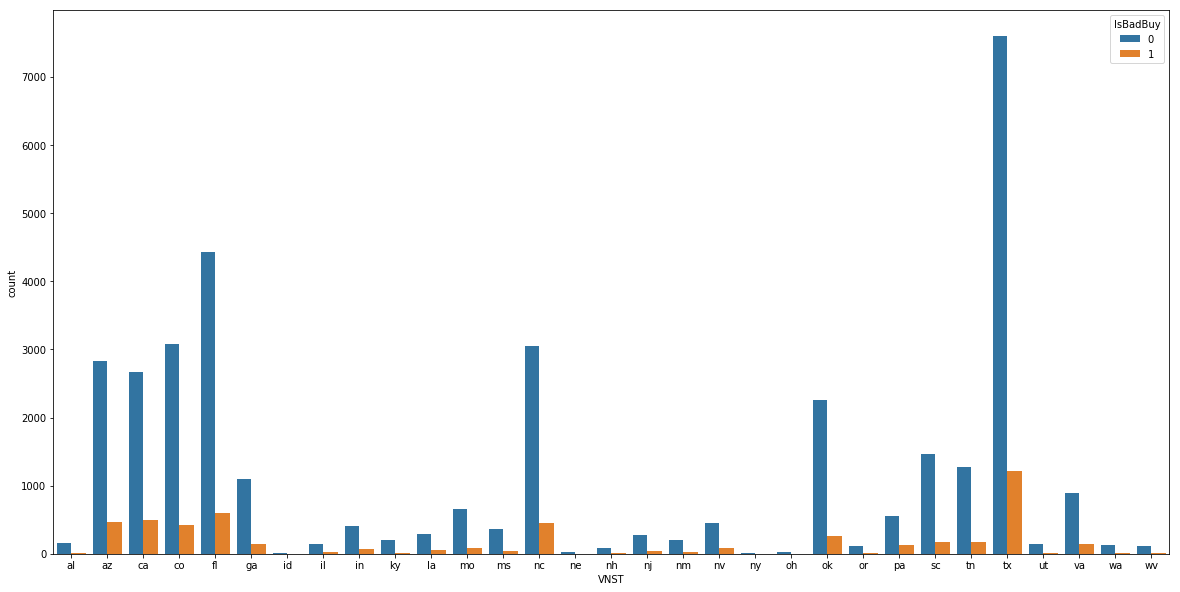

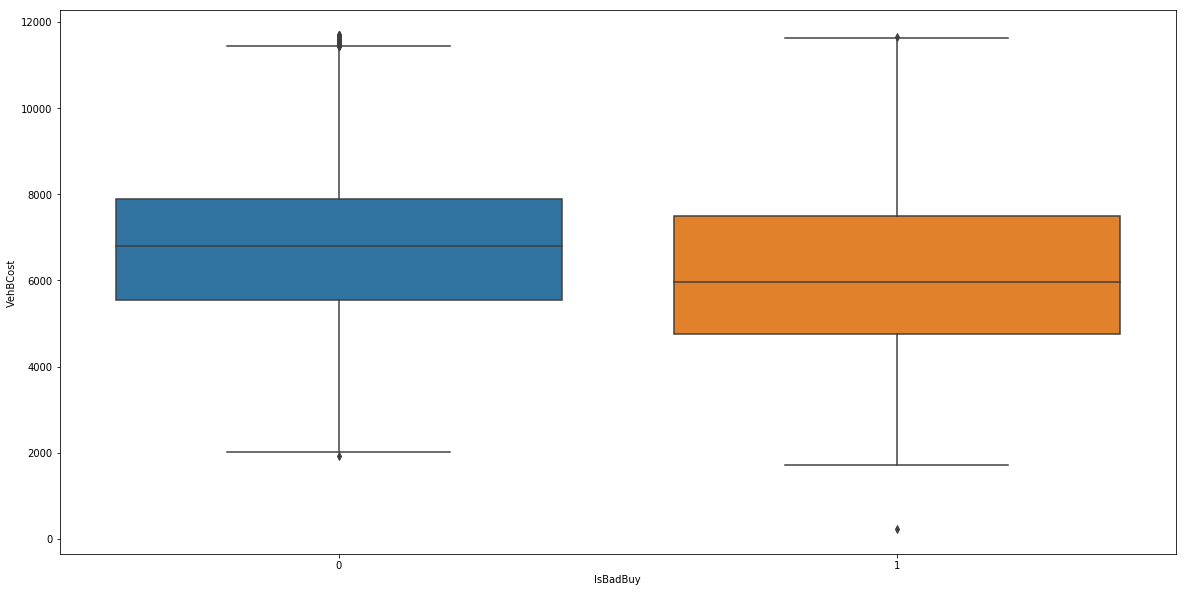

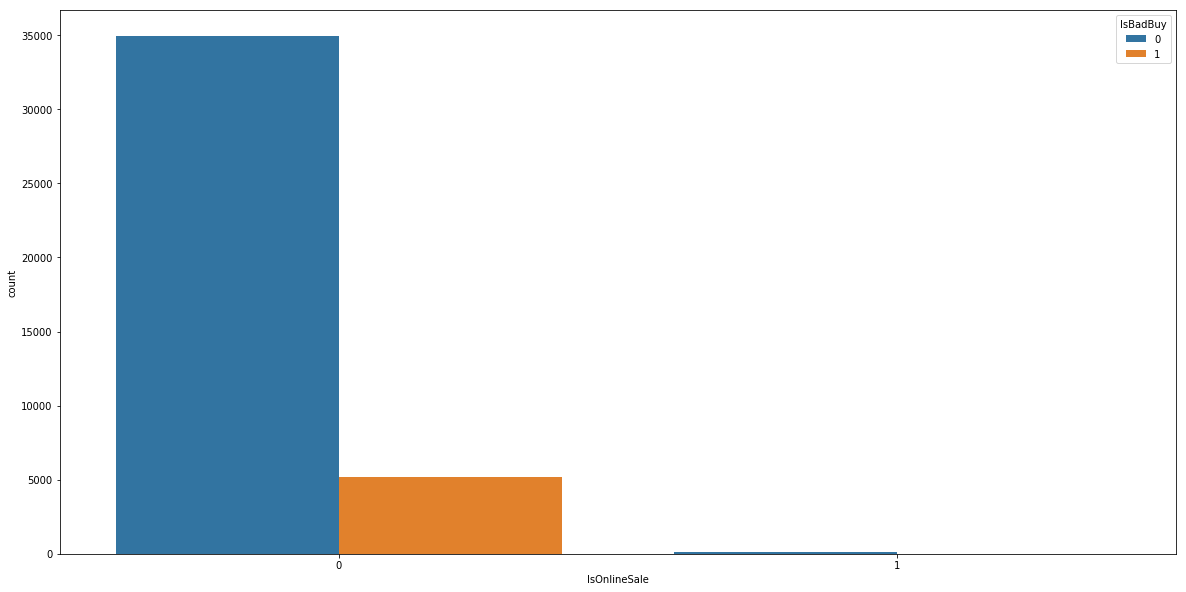

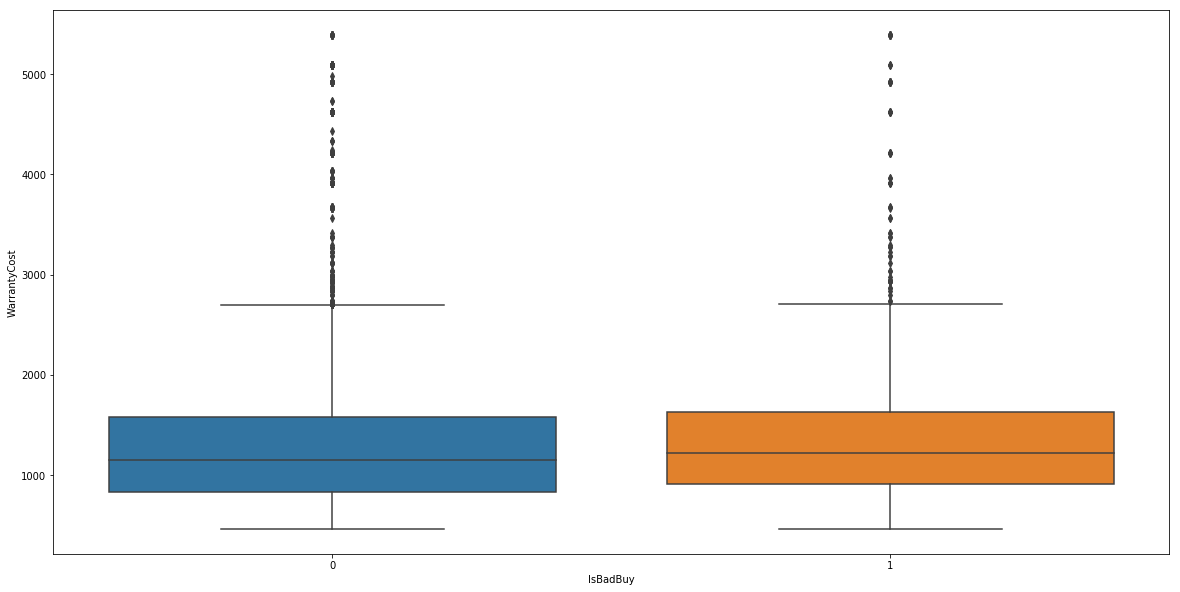

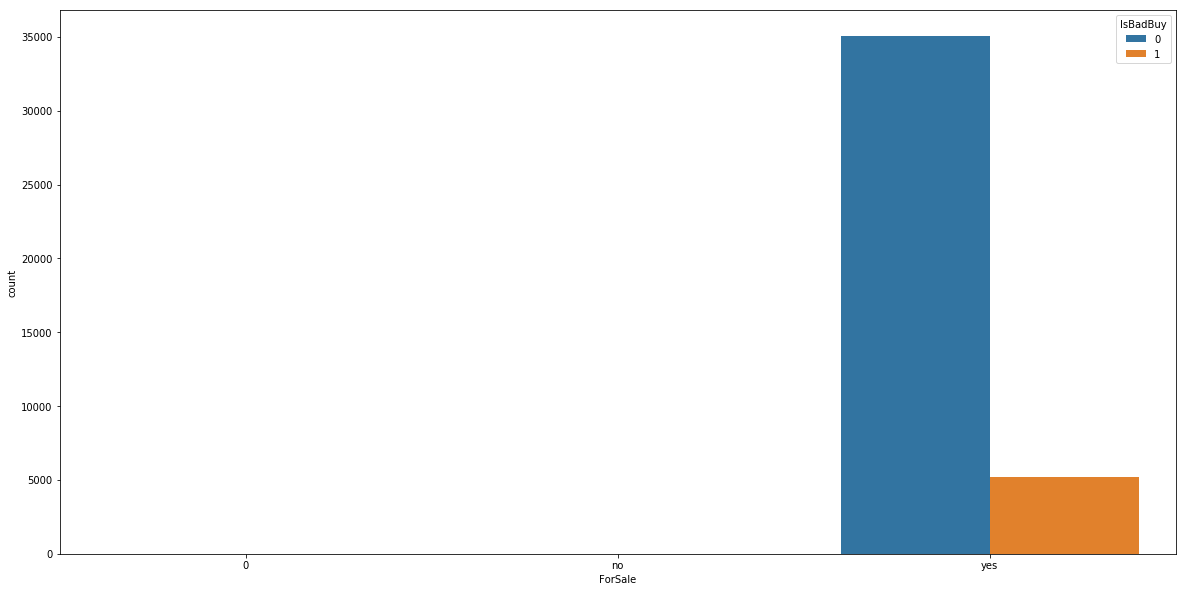

<Figure size 1440x720 with 0 Axes>

In [11]:
plotAllCols(df)

### 4. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice

### 5. What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection. 

In [12]:
# Change to the dummy 

df = pd.get_dummies(df)

feature_names = df.drop("IsBadBuy", axis=1).columns

### Split to the training and test set. 
#  The test size is 3%

# y = df['IsBadBuy']
# X = df.drop(['IsBadBuy'], axis=1)
# X_mat = X.as_matrix()

# X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

X_train, X_test, y_train, y_test = train_test_split(df.drop("IsBadBuy", axis=1), df['IsBadBuy'], test_size=0.3, stratify=df['IsBadBuy'], random_state=rs)


In [13]:
print("Number of Training: ", len(X_train))
print("Number of Test: ", len(X_test) )

Number of Training:  28156
Number of Test:  12067


# Task 2. Predictive Modeling Using Decision Trees 

## 1. Python: Build a decision tree using the default setting. 

In [14]:
def printLRTopImportant(model, top = 5):
    
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file


In [15]:
# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

### a. What is the classification accuracy on training and test datasets?

In [16]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 1.0
Test accuracy: 0.7882655175271401
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     10516
           1       0.21      0.24      0.22      1551

   micro avg       0.79      0.79      0.79     12067
   macro avg       0.55      0.55      0.55     12067
weighted avg       0.80      0.79      0.79     12067



### b. What is the size of tree (i.e. number of nodes)?

In [17]:
print("Number of nodes: ",model.tree_.node_count)

Number of nodes:  6849


### c. How many leaves are in the tree that is selected based on the validation dataset?

### d. Which variable is used for the first split? What are the competing splits for this first split? 

In [18]:
visualize_decision_tree(model, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct.png")

### e. What are the 5 important variables in building the tree? 

In [19]:
analyse_feature_importance(model, df.drop("IsBadBuy", axis=1).columns, 5)

VehOdo : 0.08657443670048924
VehBCost : 0.08163059862189834
PurchaseTimestamp : 0.07442091755640433
MMRCurrentRetailRatio : 0.07039795549794022
MMRAcquisitionAuctionCleanPrice : 0.05622527073255473


### f. Report if you see any evidence of model overfitting. 

### g. Did changing the default setting (i.e., only focus on changing the setting of the number of splits to create a node) help improving the model? Answer the above questions on the best performing tree.

## 2. Python: Build another decision tree tuned with GridSearchCV

In [95]:
confusion_matrix(y_test, y_pred)

array([[10513,     3],
       [ 1549,     2]])

In [107]:
list(range(1, 6000, 1000)) + [50]

[1, 1001, 2001, 3001, 4001, 5001, 50]

In [108]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': list(range(1, 6000, 1000)) + [None],
          'splitter': ['best', 'random'],
          'min_samples_leaf': range(1,  4),
          'min_samples_split': [2, 0.5, 0.3],
          'max_features':['auto','sqrt','log2', None],
          'n_iter_no_change': [10, 20, 30],
         }

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs, early_stopping = True), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 1001, 2001, 3001, 4001, 5001, None], 'splitter': ['best', 'random'], 'min_samples_leaf': range(1, 4), 'min_samples_split': [2, 0.5, 0.3], 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. What is the classification accuracy on training and test datasets?

In [109]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)

dt_model = cv.best_estimator_

Train accuracy: 0.8715016337547947
Test accuracy: 0.8714676390154968
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067

{'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### b. What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?

In [110]:
print("Number of nodes: ", cv.best_estimator_.tree_.node_count)

Number of nodes:  3


### c. How many leaves are in the tree that is selected based on the validation dataset?

### d. Which variable is used for the first split? What are the competing splits for this first split? 

In [24]:
visualize_decision_tree(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct_CV.png")

### e. What are the 5 important variables in building the tree? 

In [25]:
analyse_feature_importance(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, 5)

MMRAcquisitionAuctionCleanPrice : 0.5133718127146668
WheelType_alloy : 0.48662818728533325
Make_mercury : 0.0
Make_scion : 0.0
Make_saturn : 0.0


### f. Report if you see any evidence of model overfitting. 

### g. What are the parameters used? Explain your choices.

## 3. What is the significant difference do you see between these two decision tree models (steps 2.1 & 2.2)? How do they compare performance-wise? Explain why those changes may have happened. 

## 4. From the better model, can you identify which cars could potential be “kicks”? Can you provide some descriptive summary of those cars?

# Task 3. Predictive Modeling Using Regression

## 1. In preparation for regression, is any imputation of missing values needed for this data set? List the variables that needed this.

In [26]:
# We've already done this in the prep_data function

## 2. Apply transformation method(s) to the variable(s) that need it. List the variables that needed it

In [27]:
## Doing the log transformation


### Q: It's enoguh?
columns_to_transform = interval_cols

def logTransformation(df):
    
    df_log = df.copy()

    
    for col in columns_to_transform:
        df_log[col] = df_log[col].apply(lambda x: x+1)
        df_log[col] = df_log[col].apply(np.log)
        
        
    return df_log

df_log = logTransformation(df)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(df_log.drop(['IsBadBuy'], axis=1), df_log['IsBadBuy'], test_size=0.3, stratify=df_log['IsBadBuy']
,random_state=rs)

# Standardise
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)


/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/chihcheng/python3env/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


## 3. Build a regression model using the default regression method with all inputs. Once you done it, build another one and tune it using GridSearchCV. Answer the followings:

In [115]:
### Traing Logistic Regression
model = LogisticRegression(random_state=rs)
model.fit(X_train_log, y_train_log)

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [128]:
## GridSearch for Logistic Regression
params = {
    'C': [pow(10, x) for x in range(-8, -4)],
    'solver' : ['newton-cg',"lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [30, 50],
    'warm_start': [True, False],
}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1e-08, 1e-07], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [30, 50], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### h. Name the regression function used.

### i. How much was the difference in performance of two models build, default and optimal?

In [29]:
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))

Train accuracy: 0.8717857650234409
Test accuracy: 0.871633380293362
GridSearch Train accuracy: 0.8715016337547947
GridSearch Test accuracy: 0.8714676390154968


### j. Show the set parameters for the best model. What are the parameters used? Explain your decision. What are the optimal parameters?

In [30]:
print("The best model parameters: ", cv.best_params_)

The best model parameters:  {'C': 1e-06}


### k. Report which variables are included in the regression model.

### l. Report the top-5 important variables (in the order) in the model.

In [31]:
def printLRTopImportant(model, top = 5):
    
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

In [32]:
printLRTopImportant(model, 5)

MMRCurrentAuctionAveragePrice : 1.006406300870813
MMRAcquisitionAuctionAveragePrice : -0.6314165973508998
MMRAcquisitionRetailAveragePrice : 0.5493857342523841
MMRCurrentRetailAveragePrice : -0.5408757228088299
MMRAcquisitonRetailCleanPrice : 0.46259032064166566


### m. What is classification accuracy on training and test datasets?

In [33]:
y_pred = model.predict(X_test_log)
print("Classification Report: \n\n",classification_report(y_test_log, y_pred))

y_pred = cv.predict(X_test_log)
print("GridSearch Classification Report: \n\n",classification_report(y_test_log, y_pred))
log_reg_model = cv.best_estimator_

Classification Report: 

               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.53      0.01      0.02      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.70      0.51      0.48     12067
weighted avg       0.83      0.87      0.81     12067

GridSearch Classification Report: 

               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067



/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### n. Report any sign of overfitting.

In [34]:
## The GridSearch Precision and Recall is weird

## 4. Build another regression model using the subset of inputs selected by RFE and selection by model method. Answer the followings:

In [35]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train_log, y_train_log)
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

selectmodel = SelectFromModel(dt_model, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

### a. Report which variables are included in the regression model.

In [36]:
print("Original feature set", X_train.shape[1])
print("Number of RFE-selected features: ", rfe.n_features_)
print("Number of selectFromModel features: ",  X_train_sel_model.shape[1])

Original feature set 142
Number of RFE-selected features:  64
Number of selectFromModel features:  2


In [37]:
print("The RFE-selected features: \n\n", list(compress(feature_names, rfe.support_)))
print("\n\n")
print("The SelectFromModel features: \n\n",list(compress(feature_names, selectmodel.get_support())))

The RFE-selected features: 

 ['PurchaseTimestamp', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailRatio', 'VehBCost', 'WarrantyCost', 'Auction_adesa', 'Auction_manheim', 'Auction_other', 'VehYear_2001.0', 'VehYear_2002.0', 'VehYear_2003.0', 'VehYear_2004.0', 'VehYear_2005.0', 'VehYear_2007.0', 'VehYear_2008.0', 'VehYear_2009.0', 'Make_chevrolet', 'Make_dodge', 'Make_honda', 'Make_lexus', 'Make_nissan', 'Make_suzuki', 'Make_toyota', 'Make_volvo', 'Color_brown', 'Color_not avail', 'Transmission_manual', 'WheelTypeID_0', 'WheelTypeID_1', 'WheelTypeID_2', 'WheelTypeID_3', 'WheelType_alloy', 'WheelType_covers', 'WheelType_special', 'Nationality_top line asian', 'Size_large', 'Size_large suv', 'Size_medium', 'Size_medium suv', 'Size_specialty', 'TopThreeAmericanName_chrysler', 

### b. Report the top-5 important variables (in the order) in the model.

In [131]:
params = {
    'C': [pow(10, x) for x in range(-8, -4)],
    'solver' : ['newton-cg',"lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [30, 50],
    'warm_start': [True, False],
}
rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_log)

selectModel_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
selectModel_cv.fit(X_train_sel_model, y_train_log)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [30, 50], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [132]:
print("Top-5 important variables for RFE: \n")
printLRTopImportant(rfe_cv.best_estimator_, 5)
print("\n\n")
print("Top-5 important variables for selectModel \n")
printLRTopImportant(selectModel_cv.best_estimator_, 5)

Top-5 important variables for RFE: 

MMRCurrentAuctionAveragePrice : -1.2926647866209967e-05
MMRCurrentAuctionCleanPrice : -1.2538494627639429e-05
MMRCurrentRetailAveragePrice : -1.2117081112625527e-05
Make_kia : -1.2005518358305672e-05
Make_jeep : 1.199250363777549e-05



Top-5 important variables for selectModel 

VehOdo : 1.199383746863846e-05
PurchaseTimestamp : -6.464426695740191e-06


### c. What are the parameters used? Explain your choices. What are the optimal parameters? Which regression function is being used?

In [133]:
print("Optimal Parameters for RFE", rfe_cv.best_params_)
print("Optimal Parameters for selectModel", selectModel_cv.best_params_)

Optimal Parameters for RFE {'C': 1e-08, 'max_iter': 30, 'solver': 'newton-cg', 'warm_start': True}
Optimal Parameters for selectModel {'C': 1e-08, 'max_iter': 30, 'solver': 'newton-cg', 'warm_start': True}


### d. Report any sign of overfitting

### e. What is classification accuracy on training and test datasets?

In [134]:
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))
print("\n\nRFE:\n")
print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test_log))
print("\n\nselectModel:\n")
print("Train accuracy:", selectModel_cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", selectModel_cv.score(X_test_sel_model, y_test_log))

GridSearch Train accuracy: 0.8715016337547947
GridSearch Test accuracy: 0.8714676390154968


RFE:

Train accuracy: 0.8715016337547947
Test accuracy: 0.8714676390154968


selectModel:

Train accuracy: 0.8715016337547947
Test accuracy: 0.8714676390154968


### f. Did it improve/worsen the performance? Explain why those changes may have happened

In [136]:
y_pred = rfe_cv.predict(X_test_rfe)
print("REF classification report: \n",classification_report(y_test, y_pred))
print("\n\n")
y_pred = selectModel_cv.predict(X_test_sel_model)
print("selectModel classification report: \n",classification_report(y_test, y_pred))

REF classification report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067




selectModel classification report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067



/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 # Task4 - Predicting using neural network

## 1. Build a Neural Network model using the default setting. Answer the following:

In [177]:
model = MLPClassifier(random_state=rs, early_stopping=True, max_iter=200)
model.fit(X_train_log, y_train_log)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(500, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### a. What is the network architecture?

In [178]:
def printMLPArchitecture(model):

    print("Number of Layers: ",model.n_layers_ )
    print("The First layer is Input Layer, and the last layer is the output layer")
    for i, w in enumerate(model.coefs_):
        print("{} Layer with hidden size {}".format(i+1, w.shape[0]))
        if (i+1) == len(model.coefs_):
            print("{} Layer with hidden size {}".format(i+2, w.shape[1]))
    
    print("The activation function: ", model.activation)
            
printMLPArchitecture(model)

Number of Layers:  4
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 142
2 Layer with hidden size 500
3 Layer with hidden size 20
4 Layer with hidden size 1
The activation function:  relu


### b. How many iterations are needed to train this network?

In [139]:
print("Number of iterations it ran: ", model.n_iter_)

Number of iterations it ran:  200


### c. Do you see any sign of over-fitting?

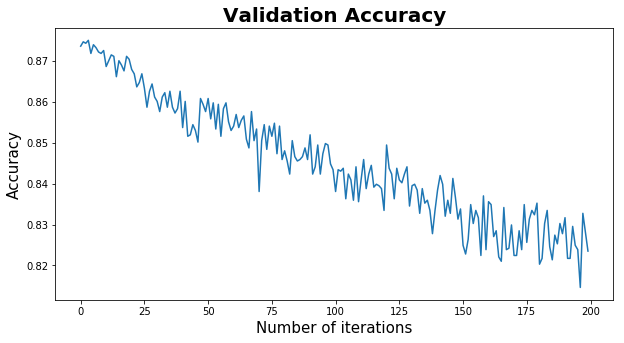

In [140]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Validation Accuracy',fontsize=20,fontweight ="bold")
plt.plot(model.validation_scores_, label="Validation Accuracy")

### d. Did the training process converge and resulted in the best model? 

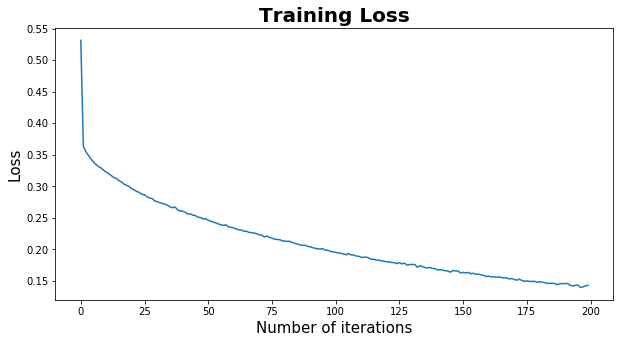

In [141]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(model.loss_curve_, label="Training Loss")

### The Loss curve is still decreasing

### e. What is classification accuracy on training and test datasets?

In [142]:
print("MLP Train accuracy:", model.score(X_train, y_train))
print("MLP Test accuracy:", model.score(X_test, y_test))
print("\n\n")
y_pred = model.predict(X_test)
print("MLP classification report: \n",classification_report(y_test, y_pred))

MLP Train accuracy: 0.8715016337547947
MLP Test accuracy: 0.8714676390154968



MLP classification report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067



/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2. Refine this network by tuning it with GridSearchCV. 

In [190]:
params = {
    'hidden_layer_sizes': [(128,)],
    'activation': ['logistic', 'relu','identity'],
    'solver' : ['sgd', 'adam'],
    'batch_size': [64,],
    'learning_rate_init': [pow(10, x) for x in range(-4, -3)],
    'n_iter_no_change': [10]
}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping = True), cv=3, n_jobs=-1)
# cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, max_iter = max_iter, n_iter_no_change = max_iter ), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(256,), (128,)], 'activation': ['identity', 'relu'], 'solver': ['sgd', 'adam'], 'batch_size': [64, 128], 'learning_rate_init': [0.0001], 'n_iter_no_change': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. What is the network architecture?

In [191]:
print("Best Parameters of NN: ", cv.best_params_)

Best Parameters of NN:  {'activation': 'identity', 'batch_size': 64, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001, 'n_iter_no_change': 10, 'solver': 'sgd'}


In [192]:
printMLPArchitecture(cv.best_estimator_)

Number of Layers:  3
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 142
2 Layer with hidden size 128
3 Layer with hidden size 1
The activation function:  identity


# b. How many iterations are needed to train this network?

In [193]:
print("Number of iterations it ran: ",cv.best_estimator_.n_iter_)

Number of iterations it ran:  20


### c. Sign of overfitting?

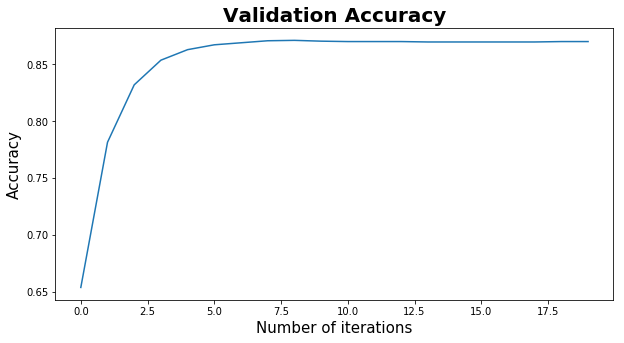

In [194]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Validation Accuracy',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.validation_scores_, label="Validation Accuracy")

### d. Did the training process converge and resulted in the best model? 

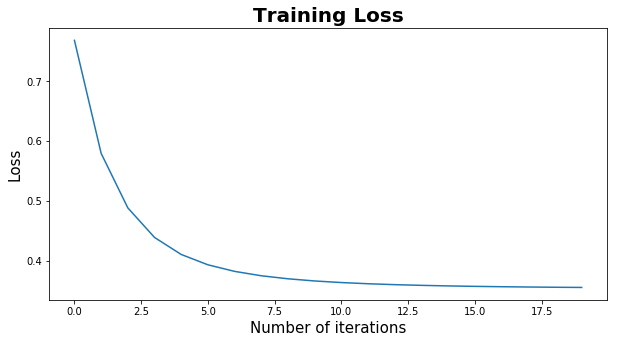

In [195]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.loss_curve_, label="Training Loss")


### e. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [197]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))

print("\n\n")
y_pred = cv.predict(X_test_log)
print("GridSearch NN Classification Report: \n",classification_report(y_test_log, y_pred))

print("Best Parameters of NN: ", cv.best_params_)
nn_model = cv.best_estimator_

GridSearch NN Train accuracy: 0.8711109532604063
GridSearch NN Test accuracy: 0.8708875445429685



GridSearch NN Classification Report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.41      0.01      0.02      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.64      0.50      0.47     12067
weighted avg       0.81      0.87      0.81     12067

Best Parameters of NN:  {'activation': 'identity', 'batch_size': 64, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001, 'n_iter_no_change': 10, 'solver': 'sgd'}


## 3. Would feature selection help here? Build another Neural Network model with inputs selected from RFE with regression (use the best model generated in Task 3) and selection with decision tree (use the best model from Task 2).

In [199]:
params = {
    'hidden_layer_sizes': [(128,)],
    'activation': ['logistic', 'relu','identity'],
    'solver' : ['sgd', 'adam'],
    'batch_size': [64,],
    'learning_rate_init': [pow(10, x) for x in range(-4, -3)],
    'n_iter_no_change': [10]
}

rfe_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_log)
modelSelect_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True), cv=10, n_jobs=-1)
modelSelect_cv.fit(X_train_sel_model, y_train_log)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(128,)], 'activation': ['logistic', 'relu', 'identity'], 'solver': ['sgd', 'adam'], 'batch_size': [64], 'learning_rate_init': [0.0001], 'n_iter_no_change': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. Did feature selection help here? Any change in the network architecture? What inputs are being used as the network input?

In [200]:
print("Best Parameters of NN: ", cv.best_params_)
print("Best Parameters of RFE NN: ", rfe_cv.best_params_)
print("Best Parameters of modelSelect NN: ", modelSelect_cv.best_params_)
print("\n\n")

print("GridSearch:")
printMLPArchitecture(cv.best_estimator_)
print("\n")
print("RFE:")
printMLPArchitecture(rfe_cv.best_estimator_)
print("\n")
print("modelSelect:")
printMLPArchitecture(modelSelect_cv.best_estimator_)
print("\n")


Best Parameters of NN:  {'activation': 'identity', 'batch_size': 64, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001, 'n_iter_no_change': 10, 'solver': 'sgd'}
Best Parameters of RFE NN:  {'activation': 'identity', 'batch_size': 64, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001, 'n_iter_no_change': 10, 'solver': 'adam'}
Best Parameters of modelSelect NN:  {'activation': 'logistic', 'batch_size': 64, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001, 'n_iter_no_change': 10, 'solver': 'sgd'}



GridSearch:
Number of Layers:  3
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 142
2 Layer with hidden size 128
3 Layer with hidden size 1
The activation function:  identity


RFE:
Number of Layers:  3
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 64
2 Layer with hidden size 128
3 Layer with hidden size 1
The activation function:  identity


modelSelect:
Number of Lay

### b. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [201]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))
print("RFE NN Train accuracy:", rfe_cv.score(X_train_rfe, y_train_log))
print("RFE NNTest accuracy:", rfe_cv.score(X_test_rfe, y_test_log))
print("modelSelect NN Train accuracy:", modelSelect_cv.score(X_train_sel_model, y_train))
print("modelSelect NN Test accuracy:", modelSelect_cv.score(X_test_sel_model, y_test))

GridSearch NN Train accuracy: 0.8711109532604063
GridSearch NN Test accuracy: 0.8708875445429685
RFE NN Train accuracy: 0.8719988634749254
RFE NNTest accuracy: 0.8722134747658904
modelSelect NN Train accuracy: 0.8715016337547947
modelSelect NN Test accuracy: 0.8714676390154968


### c. How many iterations are now needed to train this network?

In [202]:
print("Number of iterations GS ran: ",cv.best_estimator_.n_iter_)
print("Number of iterations rfe ran: ",rfe_cv.best_estimator_.n_iter_)
print("Number of iterations modelSelect ran: ",modelSelect_cv.best_estimator_.n_iter_)

Number of iterations GS ran:  20
Number of iterations rfe ran:  19
Number of iterations modelSelect ran:  12


### d. Do you see any sign of over-fitting?

### e. Did the training process converge and resulted in the best model? 

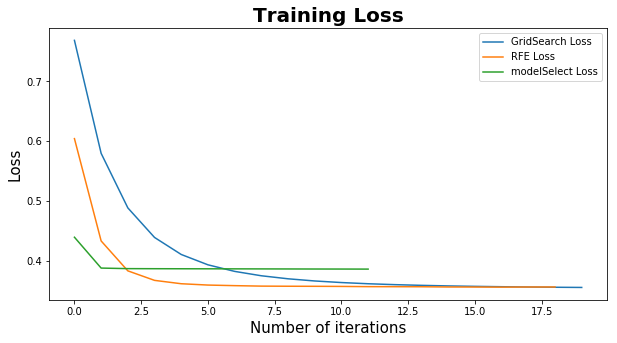

In [203]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.loss_curve_, label="GridSearch Loss")
plt.plot(rfe_cv.best_estimator_.loss_curve_, label="RFE Loss")
plt.plot(modelSelect_cv.best_estimator_.loss_curve_, label="modelSelect Loss")
plt.legend(loc='upper right')

# 4. Using the comparison methods, which of the models (i.e one with selected variables and another with all variables) appears to be better? From the better model, can you identify cars those could potential be “kicks”? Can you provide some descriptive summary of those cars? Is it easy to comprehend the performance of the best neural network model for decision making?

In [204]:
print("GridSearch Classification Report: ")
y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))
print("\n\nRFE Classification Report: ")
y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))
print("\n\nmodelSelect Classification Report: ")
y_pred = modelSelect_cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

GridSearch Classification Report: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.41      0.01      0.02      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.64      0.50      0.47     12067
weighted avg       0.81      0.87      0.81     12067



RFE Classification Report: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.74      0.01      0.02      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.80      0.50      0.47     12067
weighted avg       0.85      0.87      0.81     12067



modelSelect Classification Report: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44  

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Task 5. Generating an Ensemble Model and Comparing Models

## 1. Generate an ensemble model to include the best regression model, best decision tree model, and best neural network model.

In [205]:
voting = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')
voting.fit(X_train_log, y_train_log)

y_pred_dt = dt_model.predict(X_test_log)
y_pred_log_reg = log_reg_model.predict(X_test_log)
y_pred_nn = nn_model.predict(X_test_log)
y_pred_ensemble = voting.predict(X_test_log)


/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### a. Does the Ensemble model outperform the underlying models? Resonate your answer.

In [207]:
print("Report for DT: \n",classification_report(y_test_log, y_pred_dt))
print("\nReport for Logistic Regression: \n",classification_report(y_test_log, y_pred_log_reg))
print("\nReport for NN: \n",classification_report(y_test_log, y_pred_nn))
print("\nReport for Ensemble: \n",classification_report(y_test_log, y_pred_ensemble))

Report for DT: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067


Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.87      0.49      0.63     10516
           1       0.12      0.49      0.20      1551

   micro avg       0.49      0.49      0.49     12067
   macro avg       0.50      0.49      0.41     12067
weighted avg       0.77      0.49      0.57     12067


Report for NN: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.41      0.01      0.02      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.64      0.50      0.47     12067
weig

## 2. Use the comparison methods (or the comparison node) to compare the best decision tree model, the best regression model, the best neural network model and the ensemble model. 

### a. Discuss the findings led by (a) ROC Chart (and Index); (b) Score Ranking (or Accuracy Score); (c) Fit Statistics; (or Classification report) and (4) Output.

(a) ROC Chart (and Index)

ROC index on test for DT: 0.527032094289283
ROC index on test for logistic regression: 0.5031900056381495
ROC index on test for NN: 0.5
ROC index on voting classifier: 0.6659547246049677


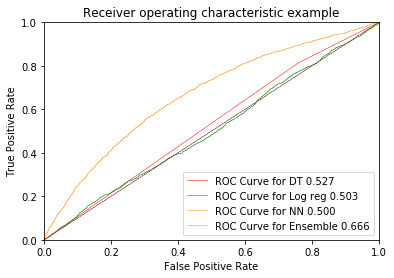

In [208]:
#### ROC

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)
y_pred_proba_ensemble = voting.predict_proba(X_test_log)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_ensemble = roc_auc_score(y_test_log, y_pred_proba_ensemble[:, 1])


print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)
print("ROC index on voting classifier:", roc_index_ensemble)


fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test, y_pred_proba_ensemble[:,1])


plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_ensemble, tpr_ensemble, label='ROC Curve for Ensemble {:.3f}'.format(roc_index_ensemble), color='darkorange', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

(b) Score Ranking (or Accuracy Score)

In [209]:
print("Accuracy score on test for DT:", accuracy_score(y_test_log, y_pred_dt))
print("Accuracy score on test for Logistic Regression:", accuracy_score(y_test_log, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test_log, y_pred_nn))
print("Accuracy score on test for Ensemble:", accuracy_score(y_test_log, y_pred_ensemble))

Accuracy score on test for DT: 0.8714676390154968
Accuracy score on test for Logistic Regression: 0.4928316897323278
Accuracy score on test for NN: 0.8708875445429685
Accuracy score on test for Ensemble: 0.8711361564597663


(c) Classification report

In [210]:
print("Report for DT: \n",classification_report(y_test_log, y_pred_dt))
print("\nReport for Logistic Regression: \n",classification_report(y_test_log, y_pred_log_reg))
print("\nReport for NN: \n",classification_report(y_test_log, y_pred_nn))
print("\nReport for Ensemble: \n",classification_report(y_test_log, y_pred_ensemble))

Report for DT: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.00      0.00      0.00      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.76      0.87      0.81     12067


Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.87      0.49      0.63     10516
           1       0.12      0.49      0.20      1551

   micro avg       0.49      0.49      0.49     12067
   macro avg       0.50      0.49      0.41     12067
weighted avg       0.77      0.49      0.57     12067


Report for NN: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     10516
           1       0.41      0.01      0.02      1551

   micro avg       0.87      0.87      0.87     12067
   macro avg       0.64      0.50      0.47     12067
weig

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(d) Output

### b. Do all the models agree on the cars characteristics? How do they vary?

# Task 6. Final Remarks: Decision Making

## 1. Finally, based on all models and analysis, is there

## 2. Can you summarise positives and negatives of each predictive modelling method based on this analysis? 

## 3. How the outcome of this study can be used by decision makers? 